##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multiple changepoint detection and Bayesian model selection


# Bayseian model selection
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports

In [0]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

##  Task: changepoint detection with multiple changepoints

Consider a changepoint detection task:  events happen at a rate that changes over time, driven by sudden shifts in the (unobserved) state of some system or process generating the data.

For example, we might observe a series of counts like the following:

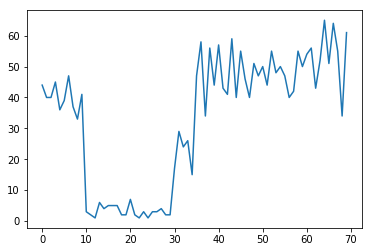

In [0]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)

plt.plot(observed_counts)

These could represent the number of failures in a datacenter, number of visitors to a webpage, number of packets on a network link, etc.

Note it's not entirely apparent how many distinct system regimes there are just from looking at the data. Can you tell where each of the three switchpoints occurs?

## Known number of states

We'll first consider the (perhaps unrealistic) case where the number of unobserved states is known a priori. Here, we'd assume we know there are four latent states.

We model this problem as a switching (inhomogeneous) Poisson process: at each point in time, the number of events that occur is Poisson distributed, and the *rate* of events is determined by the unobserved system state $z_t$:

$$x_t \sim \text{Poisson}(\lambda_{z_t})$$

The latent states are discrete: $z_t \in \{1, 2, 3, 4\}$, so $\lambda = [\lambda_1, \lambda_2, \lambda_3, \lambda_4]$ is a simple vector containing a Poisson rate for each state. To model the evolution of states over time, we'll define a simple transition model $p(z_t | z_{t-1})$: let's say that at each step we stay in the previous state with some probability $p$, and with probability $1-p$ we transition to a different state uniformly at random. The initial state is also chosen uniformly at random, so we have:

$$
\begin{align*}
z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\
z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right)
\end{align*}$$

These assumptions correspond to a [hidden Markov model](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf) with Poisson emissions. We can encode them in TFP using `tfd.HiddenMarkovModel`. First, we define the transition matrix and the uniform prior on the initial state:

In [0]:
num_states = 4

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Next, we build a `tfd.HiddenMarkovModel` distribution, using a trainable variable to represent the rates associated with each system state. We parameterize the rates in log-space to ensure they are positive-valued.

In [0]:
# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

Finally, we define the model's total log density, including a weakly-informative LogNormal prior on the rates, and run an optimizer to compute the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) fit to the observed count data.

In [0]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

In [0]:
for step in range(201):
  loss, rates = [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: log prob {} rates {}".format(step, -loss, rates))

print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

step 0: log prob -539.8363037109375 rates [ 60.120716  46.096066 115.06791   21.380898]
step 20: log prob -251.49668884277344 rates [49.44194  22.835463 42.680107  4.509814]
step 40: log prob -244.906982421875 rates [49.37409   22.341614  39.15951    2.7087321]
step 60: log prob -244.69183349609375 rates [49.476925  21.316504  40.08259    2.7874506]
step 80: log prob -244.27362060546875 rates [49.519707  22.292286  40.211983   3.0713978]
step 100: log prob -244.25796508789062 rates [49.507477  22.055244  40.16306    3.1456223]
step 120: log prob -244.2534942626953 rates [49.510178  21.981022  40.136353   3.1146054]
step 140: log prob -244.2531280517578 rates [49.514404  22.00701   40.136944   3.1029546]
step 160: log prob -244.25303649902344 rates [49.513     22.018309  40.144352   3.1072166]
step 180: log prob -244.25303649902344 rates [49.51299   22.01862   40.142887   3.1083844]
step 200: log prob -244.2530517578125 rates [49.51313   22.017632  40.142963   3.1076818]
Inferred rates:

It worked! Note that the latent states in this model are identifiable only up to permutation, so the rates we recovered are in a different order, and there's a bit of noise, but generally they match pretty well.

### Recovering the state trajectory

Now that we've fit the model, we might want to reconstruct *which* state the model believes the system was in at each timestep.

This is a *posterior inference* task: given the observed counts $x_{1:T}$ and model parameters (rates) $\lambda$, we want to infer the sequence of discrete latent variables, following the posterior distribution $p(z_{1:T} | x_{1:T}, \lambda)$. In a hidden Markov model, we can efficiently compute marginals and other properties of this distribution using standard message-passing algorithms. In particular, the `posterior_marginals` method will efficiently compute (using the [forward-backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm)) the marginal probability distribution $p(Z_t = z_t | x_{1:T})$ over the discrete latent state $Z_t$ at each timestep $t$.

In [0]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

Plotting the posterior probabilities, we recover the model's "explanation" of the data: at which points in time is each state active?

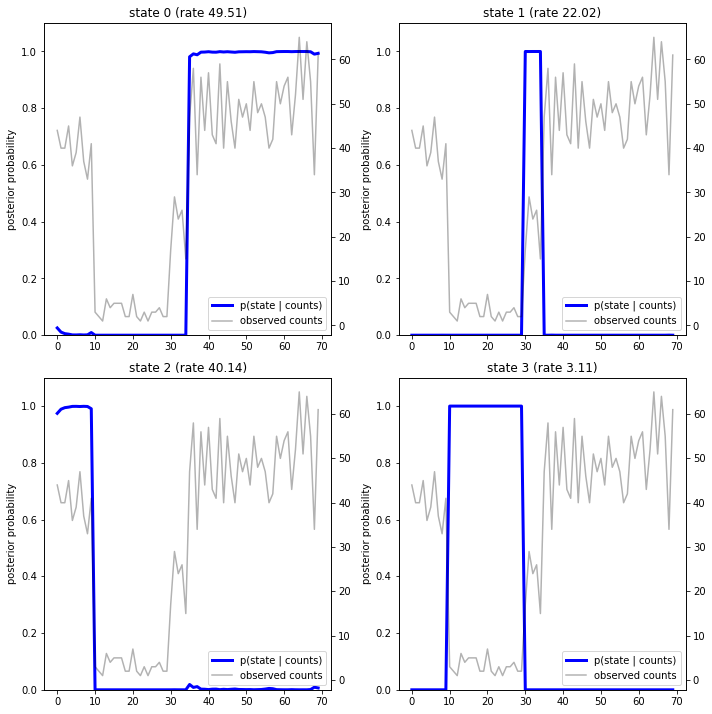

In [0]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

In this (simple) case, we see that the model is usually quite confident: at most timesteps it assigns essentially all probability mass to a single one of the four states. Luckily, the explanations look reasonable!

We can also visualize this posterior in terms of the rate associated with the *most likely* latent state at each timestep, condensing the probabilistic posterior into a single explanation:

In [0]:
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_rates = rates[most_probable_states]

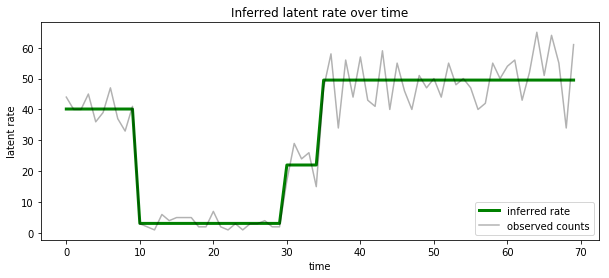

In [0]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

Technical note: instead of the most probable state at each individual timestep, $z^*_t = \text{argmax}_{z_t} p(z_t | x_{1:T})$, we could have asked for the most probable latent *trajectory*, $z^* = \text{argmax}_z p(z | x_{1:T})$ (or even samples from the posterior over trajectories!), taking dependence between timesteps into account. To illustrate the difference, suppose a rock-paper-scissors player plays rock 40% of the time, but never twice in a row: rock may be the most likely marginal state at every point in time, but "rock, rock, rock...'' is definitely *not* the most likely trajectory -- in fact, it has zero probability!

TODO(davmre): once `tfp.HiddenMarkovModel` implements the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) to find highest-probability trajectories, update this section to use it.

## Unknown number of states

In real problems, we may not know the 'true' number of states in the system we're modeling. This may not always be a concern: if you don't particularly care about the identities of the unknown states, you could just run a model with more states than you know the model will need, and learn (something like) a bunch of duplicate copies of the actual states. But let's assume you do care about inferring the 'true' number of latent states.

We can view this as a case of [Bayesian model selection](http://alumni.media.mit.edu/~tpminka/statlearn/demo/): we have a set of candidate models, each with a different number of latent states, and we want to choose the one that is most likely to have generated the observed data. To do this, we compute the marginal likelihood of the data under each model (we could also add a prior on the models themselves, but that won't be necessary in this analysis; the [Bayesian Occam's razor](https://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/MacKay2003-Ch28.pdf) turns out to be sufficient to encode a preference towards simpler models).

Unfortunately, the true marginal likelihood, which integrates over both the discrete states $z_{1:T}$ and the (vector of) rate parameters $\lambda$, $$p(x_{1:T}) = \int p(x_{1:T}, z_{1:T}, \lambda) dz d\lambda,$$ is not tractable for this model. For convenience, we'll approximate it using a so-called "[empirical Bayes](https://www.cs.ubc.ca/~schmidtm/Courses/540-W16/L19.pdf)" or "type II maximum likelihood" estimate: instead of fully integrating out the (unknown) rate parameters $\lambda$ associated with each system state, we'll optimize over their values:

$$\tilde{p}(x_{1:T}) = \max_\lambda \int p(x_{1:T}, z_{1:T}, \lambda) dz$$

This approximation may overfit, i.e., it will prefer more complex models than the true marginal likelihood would. We could consider more faithful approximations, e.g., optimizing a variational lower bound, or using a Monte Carlo estimator such as [annealed importance sampling](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_annealed_importance_chain); these are (sadly) beyond the scope of this notebook. (For more on Bayesian model selection and approximations, chapter 7 of the excellent [Machine Learning: a Probabilistic Perspective
](https://www.cs.ubc.ca/~murphyk/MLbook/) is a good reference.)

In principle, we could do this model comparison simply by rerunning the optimization above many times with different values of `num_states`, but that would be a lot of work. Here we'll show how to consider multiple models in parallel, using TFP's `batch_shape` mechanism for vectorization.

**Transition matrix and initial state prior**: rather than building a single model description, now we'll build a *batch* of transition matrices and prior logits, one for each candidate model up to `max_num_states`. For easy batching we'll need to ensure that all computations have the same 'shape': this must correspond to the dimensions of the largest model we'll fit. To handle smaller models, we can  'embed' their descriptions in the topmost dimensions of the state space, effectively treating the remaining dimensions as dummy states that are never used.

In [0]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


Now we proceed similarly as above. This time we'll use an extra batch dimension in `trainable_rates` to separately fit the rates for each model under consideration.

In [0]:
trainable_log_rates = tf.Variable(
    (np.log(np.mean(observed_counts)) *
     np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
     tf.random.normal([1, max_num_states])),
     name='log_rates')
    
hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

In computing the total log prob, we are careful to sum over only the priors for the rates actually used by each model component:


In [0]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

In [0]:
@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

Now we optimize the *batch* objective we've constructed, fitting all candidate models simultaneously:

In [0]:
for step in range(201):
  loss, rates =  [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: loss {}".format(step, loss))

step 0: loss [932.1646  832.1462  828.4412  837.84705 846.1599  417.9551  419.0383
 417.9084  425.87964 366.82443]
step 20: loss [807.2557  286.25125 257.90186 256.22498 262.71576 270.11447 279.765
 267.6623  276.87903 284.21024]
step 40: loss [803.20874 279.9999  254.07617 254.04176 262.7116  257.1419  265.64944
 263.69067 270.1178  278.18292]
step 60: loss [803.0721  271.3898  244.30405 244.61728 252.61594 256.8096  263.2815
 261.81732 268.69806 277.49   ]
step 80: loss [802.9     271.44714 244.07954 244.36232 252.20078 256.4545  261.7729
 260.18414 267.57748 276.11465]
step 100: loss [802.9022  271.3092  243.98022 244.25925 251.41597 256.0926  260.91467
 257.74948 265.95273 275.0009 ]
step 120: loss [802.8999  271.30957 243.9751  244.25511 250.79546 255.72038 260.2765
 256.68982 264.83832 274.82697]
step 140: loss [802.89966 271.3077  243.97357 244.25308 250.65877 255.32945 259.61533
 255.69922 264.014   274.46405]
step 160: loss [802.8996  271.3077  243.97354 244.25311 250.64474 25

Text(0.5, 1.0, 'Model selection on latent states')

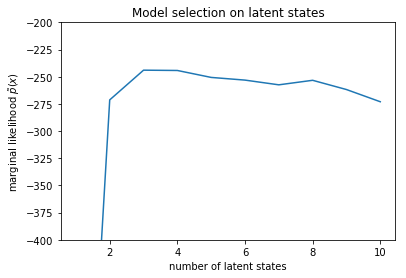

In [0]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -loss)
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

Examining the likelihoods, we see that the (approximate) marginal likelihood prefers a three- or four-state model (the specific ordering may vary between runs of this notebook). This seems quite plausible -- the 'true' model had four states, but from just looking at the data it's hard to rule out a three-state explanation.


We can also extract the rates fit for each candidate model:

In [0]:
for i, learned_model_rates in enumerate(rates):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

rates for 1-state model: [32.98682]
rates for 2-state model: [44.949432   3.1397576]
rates for 3-state model: [22.019554   3.1073658 47.4462   ]
rates for 4-state model: [22.01749    3.1073527 49.513165  40.14324  ]
rates for 5-state model: [22.016987   3.1073353 49.470993  40.127758  49.488205 ]
rates for 6-state model: [22.016418    0.12033073 50.25381    40.12794    48.88818     3.1076846 ]
rates for 7-state model: [4.9506187e+01 2.2016148e+01 4.9468941e+01 4.7518797e-03 4.9311584e+01
 3.1077573e+00 4.0113823e+01]
rates for 8-state model: [4.0115150e+01 4.3629836e-02 4.9482445e+01 4.5004072e-05 3.1080871e+00
 5.0322604e-01 4.9483521e+01 2.2015779e+01]
rates for 9-state model: [4.0034302e+01 7.8987077e-02 4.9487354e+01 3.3131179e-03 4.0034004e+01
 4.7514364e-01 4.9488628e+01 2.2016052e+01 3.1080682e+00]
rates for 10-state model: [39.950623    3.0235524  39.950375    0.16000797 39.950424   21.830935
 21.831202    3.0232046  49.51654     3.0235553 ]


And plot the explanations each model provides for the data:

In [0]:
posterior_probs = hmm.posterior_marginals(
    observed_counts).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

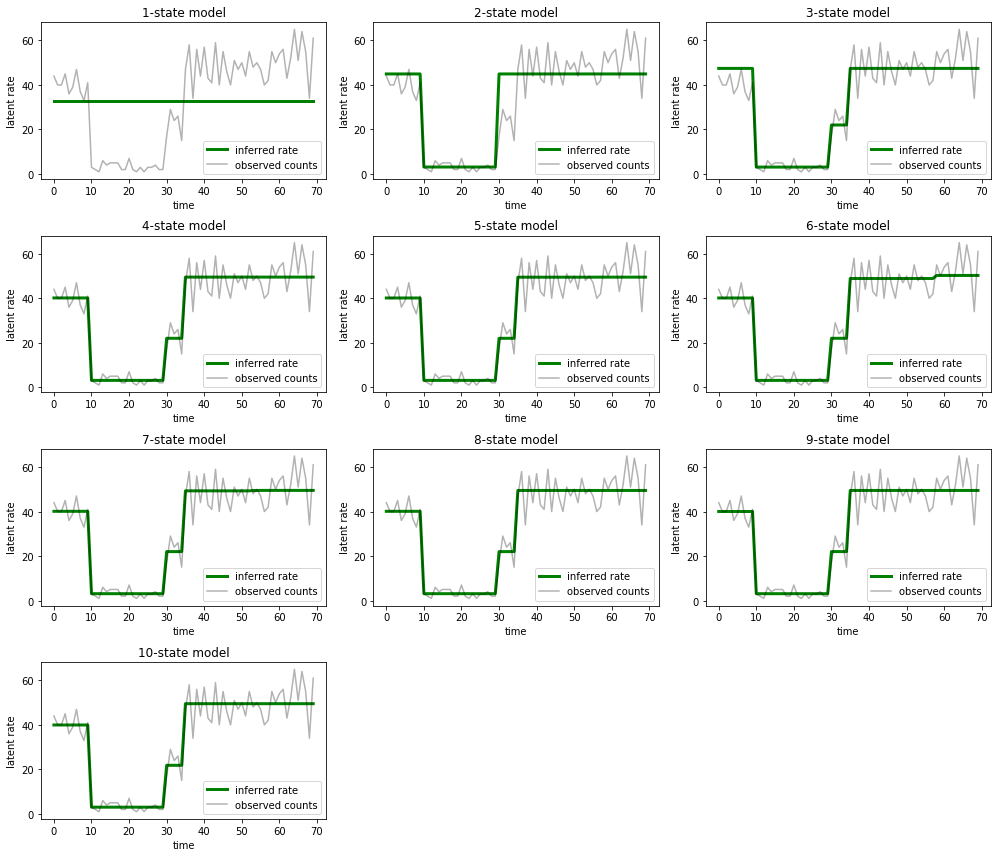

In [0]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()

It's easy to see how the one-, two-, and (more subtly) three-state models provide inadequate explanations. Interestingly, all models above four states provide essentially the same explanation! This is likely because our 'data' is relatively clean and leaves little room for alternative explanations; on messier real-world data we would expect the higher-capacity models to provide progressively better fits to the data, with some tradeoff point where the improved fit is outweighted by model complexity.

### Extensions

The models in this notebook could be straightforwardly extended in many ways. For example:

- allowing latent states to have different probabilities (some states may be common vs rare)
- allowing nonuniform transitions between latent states (e.g., to learn that a machine crash is usually followed by a system reboot is usually followed by a period of good performance, etc.)
- other emission models, e.g. `NegativeBinomial` to model varying dispersions in count data, or continous distributions such as `Normal` for real-valued data.
